In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.metrics import mean_squared_error
from scipy.stats import pointbiserialr
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read data into dataframe
df = pd.read_csv("babies.csv")

In [3]:
print(df.head(), "\n\n")
print(df.info(), "\n\n")
print(df.isnull().sum(), "\n\n")
print(df.describe())

   case  bwt  gestation  parity   age  height  weight  smoke
0     1  120      284.0       0  27.0    62.0   100.0    0.0
1     2  113      282.0       0  33.0    64.0   135.0    0.0
2     3  128      279.0       0  28.0    64.0   115.0    1.0
3     4  123        NaN       0  36.0    69.0   190.0    0.0
4     5  108      282.0       0  23.0    67.0   125.0    1.0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   case       1236 non-null   int64  
 1   bwt        1236 non-null   int64  
 2   gestation  1223 non-null   float64
 3   parity     1236 non-null   int64  
 4   age        1234 non-null   float64
 5   height     1214 non-null   float64
 6   weight     1200 non-null   float64
 7   smoke      1226 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 77.4 KB
None 


case          0
bwt           0
gestation    13
parity        0
ag

In [396]:
#drop nulls
df.dropna(axis=0, inplace=True, ignore_index=True)

#remove non-binary values for binary variables
df = df.loc[(df['parity'] % 1 == 0) & (df['smoke'] % 1 == 0)]

#convert binary variable to int from float
df['smoke'] = df['smoke'].astype('int64')

Since null values were such a small proportion of the dataset and their presence did not appear to correlate with any other subgroup within the data, their rows could be dropped without woorying about introducing significant bias.

Text(0, 0.5, 'count')

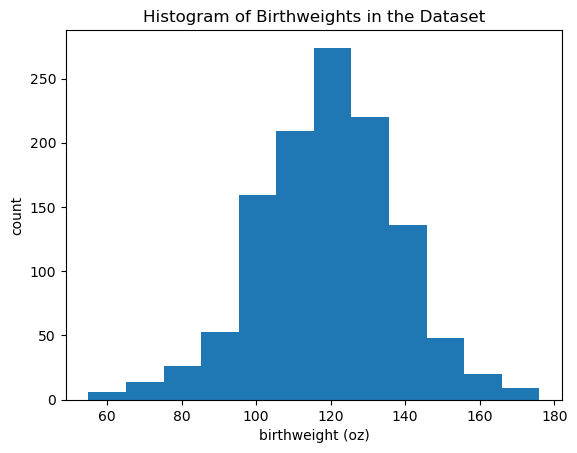

In [398]:
#plot histogram of birthweights
plt.hist(df['bwt'], bins=12)
plt.title("Histogram of Birthweights in the Dataset")
plt.xlabel("birthweight (oz)")
plt.ylabel("count")

The distribution of birthweight is roughly symmetrical and unimodal, suggesting that the data is distributed approximately normally. The tails of the distribution taper off somewhat abruptly; the vast majority of birthweights are between 100 and 140 ounces.

([<matplotlib.axis.YTick at 0x27e573cd910>,
 [Text(0, 0, 'bwt'),
  Text(0, 1, 'gestation'),
  Text(0, 2, 'age'),
  Text(0, 3, 'height'),
  Text(0, 4, 'weight'),
  Text(0, 5, 'smoke'),
  Text(0, 6, 'parity')])

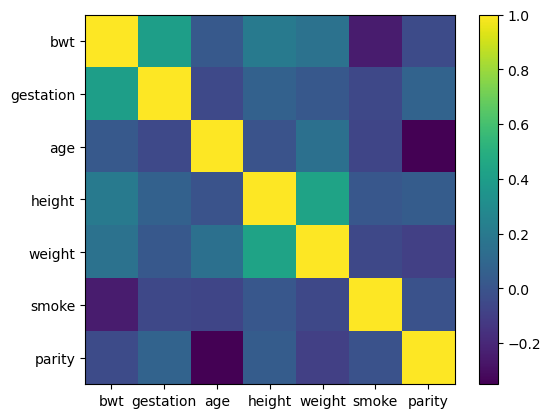

In [401]:
#create correlation matrix
cont_vars = ['bwt', 'gestation', 'age', 'height', 'weight', 'smoke', 'parity']
mtx = df[cont_vars].corr()

#display matrix
plt.imshow(mtx)
plt.colorbar()
plt.xticks(range(len(mtx)), cont_vars)
plt.yticks(range(len(mtx)), cont_vars)

In [402]:
#get variable correlations to birthweight
corr_target = mtx["bwt"].sort_values(ascending=False)
corr_target

bwt          1.000000
gestation    0.407543
height       0.203704
weight       0.155923
age          0.026983
parity      -0.043908
smoke       -0.246800
Name: bwt, dtype: float64

None of the variables seem to have a particularly strong correlation with each other, and though there can be somewhat of a relationship presumed between variables like height and weight, there do not appear strong enough to warrant removing variables. When examining the correlation between the variables and the target, some of the variables, namely age and parity appear very weakly correlated, but with the relatively small number of total variables and data, as well as a lack of contextual reasoning to determine the variables irrelevant, they are also not worth removing from feature selection.

In [405]:
#separate the features and labels
X = df[['parity', 'gestation', 'age', 'height', 'weight', 'smoke']]
y = df['bwt']

#separate the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Since the categorical variables are binary, there is no encoding necessary.

In [408]:
#create and train a random forest model
rf = RFR(random_state=10)
rf.fit(X_train, y_train)

#use the model to make predictions
preds = rf.predict(X_test)

In [410]:
#get the error of the predictions and display
mse = mean_squared_error(y_test, preds)
print("rmse:", round(mse**0.5, 3))

rmse: 15.982


The model has a root mean squared error of 16.628, indicating a mediocre performance.

The model was not particularly good at preicting birthweight based on the features selected. The standard deviation within birthweight was 18.23, so the random forest model performed only slightly better than a model that predicts the mean every time. Considering a mean value of about 120, the scale of the error is not terrible , but there is room for improvement.

In [414]:
errors = {}

#train and test random forest models with different n_estimators values
for n in [5, 10, 20, 50, 100]:
    rf = RFR(random_state = 10, n_estimators=n)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    error = round(mean_squared_error(y_test, preds)**0.5, 2)
    errors[n] = error

#display results
print(errors)

{5: 17.26, 10: 16.71, 20: 16.46, 50: 16.2, 100: 15.98}


The model with n_estimators=100 performed the best, but the process shows diminishing returns as n increases, and there is potential for overfitting when continuting to increase n.

In [417]:
#create and train a k neighbors model
knr = KNR()
knr.fit(X_train, y_train)

#use the model to make predictions
preds = knr.predict(X_test)

In [418]:
#get the error of the predictions and display
mse = mean_squared_error(y_test, preds)
print("rmse:", round(mse**0.5, 3))

rmse: 17.048


In [419]:
errors = {}

#train and test k neighbors models with different n_neighbors values
for k in [5, 6, 7, 8, 9, 10]:
    knr = KNR(n_neighbors=k)
    knr.fit(X_train, y_train)
    preds = knr.predict(X_test)
    errors[k] = round(mean_squared_error(y_test, preds)**0.5, 2)

#display results
print(errors)

{5: 17.05, 6: 16.79, 7: 16.46, 8: 16.39, 9: 16.2, 10: 16.08}


The model with n_neighbors=8 performed the best.

In this investigation, KNN proved to be a slightly better predictor for birthweight than RFR. The optimized RFR model had a root mean squared error of 16.63, while the optimized KNN model had an error of 16.22. This makes sense, as KNN peforms well for low dimensional data and is very simple in its implementation. However, there are more hyperparameters that can be tuned for random forests, and it is more robust against noise, so with less preprocessing and more attention to tuning, it could potentially perform better.

Text(0.5, 0, 'feature')

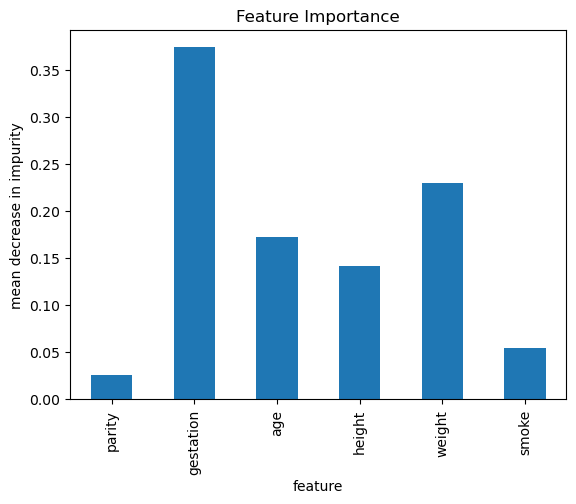

In [441]:
#train optimized model
rf = RFR(random_state = 10, n_estimators=100)
rf.fit(X_train, y_train)

#get feature importances with names
imps = rf.feature_importances_
rf_imps = pd.Series(imps, index=['parity', 'gestation', 'age', 'height', 'weight', 'smoke'])

#plot
fig, ax = plt.subplots()
rf_imps.plot.bar(ax=ax)
ax.set_title("Feature Importance")
ax.set_ylabel("mean decrease in impurity")
ax.set_xlabel("feature")

Gestation displays the highest importance, with height, age, and weight being about half as important. Smoke and parity do not appear to be very important. These findings mostly match the independant correlation between the features and birthweight examined earlier, except for age, which is noticeably more important than its correlation to birthweight suggests.